In [1]:
#imports
#Main Library (Actual Neural Network Part)
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models

# #Helper Libraries (in order to interpret and view the data)
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Prints if a GPU is detected by the TensorFlow system
print(len(tf.config.list_physical_devices('GPU')) > 0)

True


In [3]:
#importing the MNIST dataset from tensorflow
from tensorflow.keras.datasets import mnist 
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

[3]
[2]
[1]
[18]
[4]
[8]
[11]
[0]
[61]
[7]


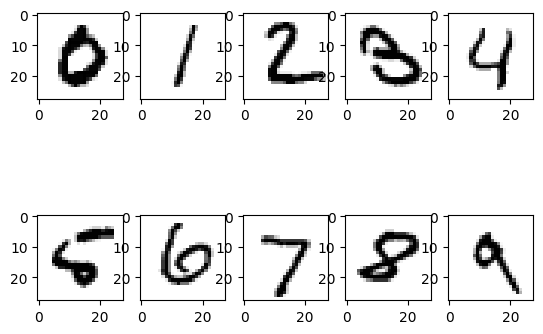

In [49]:
#validating the data (making sure this is the data I want)
fig, ax = plt.subplots(2,5)
ax = ax.flatten()
for i in range(10):
    im_idx = np.argwhere(Y_test == i)[0]
    print(im_idx)
    plottable_image = np.reshape(X_test[im_idx], (28, 28))
    ax[i].imshow(plottable_image, cmap='gray_r')

In [5]:
#checking the format of the data because I want the data to be scaled from 0 to 1
print(X_train[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 18

In [6]:
#scaling the data from 0 to 1 as float (decimal) numbers
X_train, X_test = X_train / 255.0, X_test / 255.0

In [7]:
#loading the model
model = tf.keras.models.load_model('complete_saved_mnist_model')

In [8]:
#checking if the model is valid and loaded
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 4)         40        
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 4)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 16)        592       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 3, 32)          4640      
                                                                 
 flatten_2 (Flatten)         (None, 288)              

In [21]:
#premiliminary testing (accuracy of benign images)
model.evaluate(x = X_test, y = Y_test)

313/313 [==============================] - 3s 9ms/step - loss: 0.0696 - accuracy: 0.9877


[0.06955765187740326, 0.9876999855041504]

In [22]:
#Data Preperation
image_test = tf.convert_to_tensor(X_test)
image_prob = model.predict(image_test)


In [44]:
#Creating the adversarial attack
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def create_adv(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)

  gradient = tape.gradient(loss, input_image)
  signed_grad = tf.sign(gradient)
  return signed_grad

def fgsm(input_image, input_label, eps=0.25):
  perturbation = create_adv(input_image, input_label)
  adv_image = input_image + perturbation * eps
  adv_image = tf.clip_by_value(adv_image, 0, 1)

  return adv_image

def pgd(input_image, input_label, num_steps=100, eps=0.25, alpha=0.01):
  adv_image = input_image
  for i in range(num_steps):
    adv_image = fgsm(adv_image, input_label, alpha)
    perturbation = adv_image - input_image
    perturbation = tf.clip_by_value(perturbation, -eps, eps)
    adv_image = input_image + perturbation
  
  return adv_image

adv_x = pgd(image_test, Y_test)
adv_x = np.asarray(adv_x)

[3]
[2]
[1]
[18]
[4]
[8]
[11]
[0]
[61]
[7]


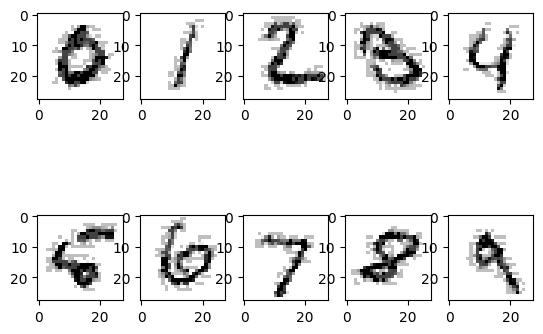

In [53]:
fgsm_x = fgsm(image_test, Y_test)
fgsm_x = np.asarray(fgsm_x)
#validating the fgsm data
fig, ax = plt.subplots(2,5)
ax = ax.flatten()
for i in range(10):
    im_idx = np.argwhere(Y_test == i)[0]
    print(im_idx)
    plottable_image = np.reshape(fgsm_x[im_idx], (28, 28))
    ax[i].imshow(plottable_image, cmap='gray_r')

In [56]:
#testing fgsm attack
model.evaluate(x = fgsm_x, y = Y_test)

313/313 [==============================] - 3s 9ms/step - loss: 2.3450 - accuracy: 0.6550


[2.344963550567627, 0.6549999713897705]


[3]
[2]
[1]
[18]
[4]
[8]
[11]
[0]
[61]
[7]


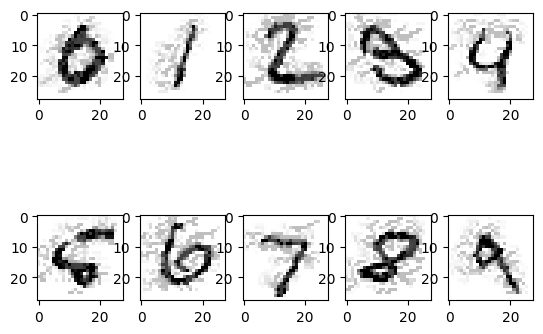

In [50]:
#validating the pgd attacked data
print()
fig, ax = plt.subplots(2,5)
ax = ax.flatten()
for i in range(10):
    im_idx = np.argwhere(Y_test == i)[0]
    print(im_idx)
    plottable_image = np.reshape(adv_x[im_idx], (28, 28))
    ax[i].imshow(plottable_image, cmap='gray_r')

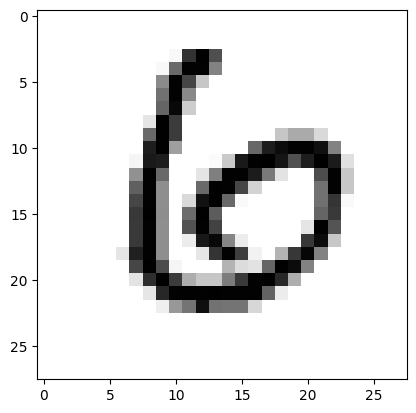

In [51]:
#shows the benign image
#allows me to test specific images
testing_index = 11
plottable_image = np.reshape(X_test[testing_index], (28, 28))
plt.imshow(plottable_image, cmap='gray_r')


In [25]:
#benign image prediction
model.predict(np.expand_dims(X_test[testing_index], axis = 0))

array([[1.8763044e-09, 3.6523529e-16, 5.7253906e-16, 6.8611468e-19,
        3.4802915e-15, 1.4336927e-13, 1.0000000e+00, 2.1867797e-20,
        5.0367869e-14, 7.6589265e-18]], dtype=float32)

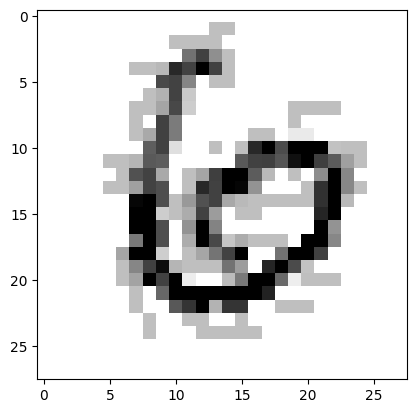

In [54]:
#shows the malignant (fgsm) image
plottable_image = np.reshape(fgsm_x[testing_index], (28, 28))
plt.imshow(plottable_image, cmap='gray_r')

In [55]:
#malignant (fgsm) image prediction
model.predict(np.expand_dims(fgsm_x[testing_index], axis = 0))

array([[1.9721454e-01, 6.7598093e-12, 1.2945791e-08, 7.5426948e-12,
        3.0531895e-13, 1.5251514e-08, 8.0278540e-01, 1.3008640e-15,
        4.0910231e-09, 3.7285812e-12]], dtype=float32)

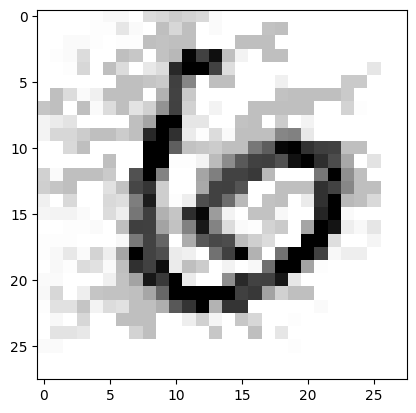

In [52]:
#shows the malignant (pgd) image
plt.figure()
plt.imshow(adv_x[testing_index]*0.5+0.5, cmap = "gray_r")

In [27]:
#malignant (pgd) image prediction
model.predict(np.expand_dims(adv_x[testing_index], axis = 0))

array([[1.0000000e+00, 3.1501361e-15, 3.0411492e-16, 7.6344984e-14,
        1.5188795e-22, 1.3889732e-13, 9.2608298e-19, 6.3128631e-17,
        1.9212200e-14, 1.8058686e-11]], dtype=float32)

In [28]:
#overall malignant (pgd) accuracy
model.evaluate(x = adv_x, y = Y_test)


313/313 [==============================] - 2s 8ms/step - loss: 24.4265 - accuracy: 0.0028


[24.426542282104492, 0.00279999990016222]